In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm import tqdm
import os
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

torch.manual_seed(47)
np.random.seed(47)
random.seed(47)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

Training set size: 5400
Validation set size: 600
Test set size: 1000
VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (embedding_layer): Sequential(
    (0): LayerNorm((64,), eps=1e-05

Epoch 1/5 [Train]: 100%|██████████| 43/43 [00:05<00:00,  8.31it/s, acc=0.156, cls_loss=2.26, loss=3.71, triplet=2.91]


Train - Cls Loss: 2.2899, Triplet Loss: 8.3068


Epoch 1/5 [Val]: 100%|██████████| 5/5 [00:00<00:00, 14.15it/s, acc=0.172, loss=2.27]


Epoch 1/5: Train Loss: 6.4432, Train Acc: 0.1563, Val Loss: 2.2685, Val Acc: 0.1717
New best model saved with validation accuracy: 0.1717


Epoch 2/5 [Train]: 100%|██████████| 43/43 [00:05<00:00,  7.64it/s, acc=0.196, cls_loss=2.25, loss=4.54, triplet=4.59]


Train - Cls Loss: 2.2586, Triplet Loss: 7.9492


Epoch 2/5 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.65it/s, acc=0.167, loss=2.22]


Epoch 2/5: Train Loss: 6.2332, Train Acc: 0.1963, Val Loss: 2.2214, Val Acc: 0.1667


Epoch 3/5 [Train]: 100%|██████████| 43/43 [00:05<00:00,  8.53it/s, acc=0.196, cls_loss=2.17, loss=3.28, triplet=2.21]


Train - Cls Loss: 2.2243, Triplet Loss: 7.3554


Epoch 3/5 [Val]: 100%|██████████| 5/5 [00:00<00:00, 14.40it/s, acc=0.15, loss=2.2]


Epoch 3/5: Train Loss: 5.9020, Train Acc: 0.1959, Val Loss: 2.1885, Val Acc: 0.1500


Epoch 4/5 [Train]: 100%|██████████| 43/43 [00:05<00:00,  7.63it/s, acc=0.193, cls_loss=2.16, loss=3.21, triplet=2.08]


Train - Cls Loss: 2.1882, Triplet Loss: 6.8672


Epoch 4/5 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.29it/s, acc=0.19, loss=2.16]


Epoch 4/5: Train Loss: 5.6218, Train Acc: 0.1928, Val Loss: 2.1647, Val Acc: 0.1900
New best model saved with validation accuracy: 0.1900


Epoch 5/5 [Train]: 100%|██████████| 43/43 [00:06<00:00,  6.90it/s, acc=0.218, cls_loss=2.2, loss=4.34, triplet=4.29]


Train - Cls Loss: 2.1700, Triplet Loss: 6.0937


Epoch 5/5 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.77it/s, acc=0.203, loss=2.15]


Epoch 5/5: Train Loss: 5.2168, Train Acc: 0.2178, Val Loss: 2.1467, Val Acc: 0.2033
New best model saved with validation accuracy: 0.2033
Best validation accuracy: 0.2033


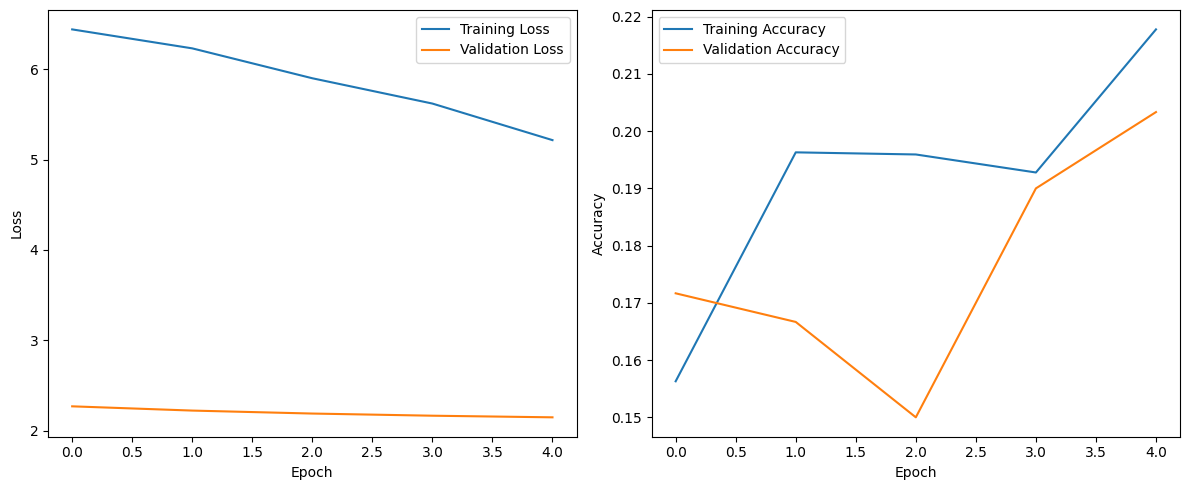

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 32.80it/s]


Test Accuracy: 0.2120
Evaluation Time: 0.25 seconds


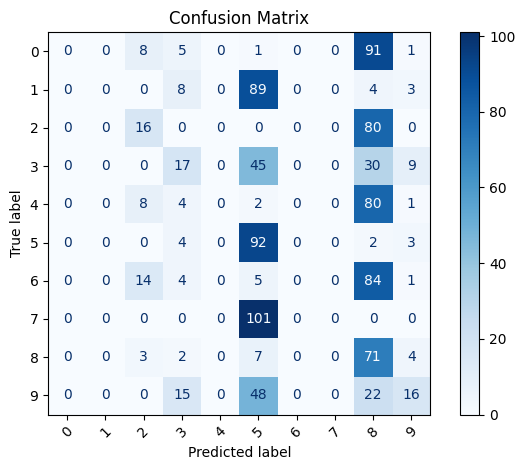

Extracting embeddings: 100%|██████████| 8/8 [00:00<00:00, 28.23it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Performing t-SNE dimensionality reduction...


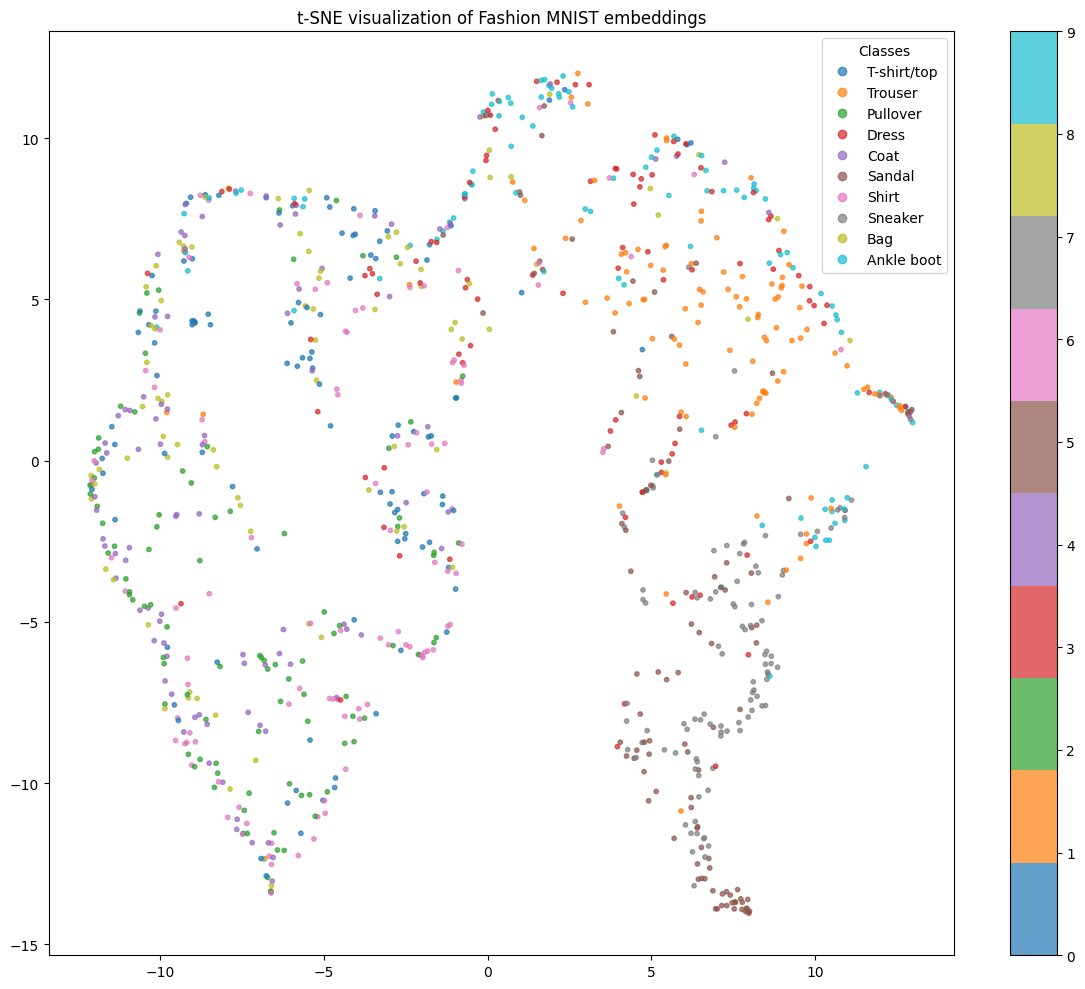

Precision@5 for retrieval: 0.3364


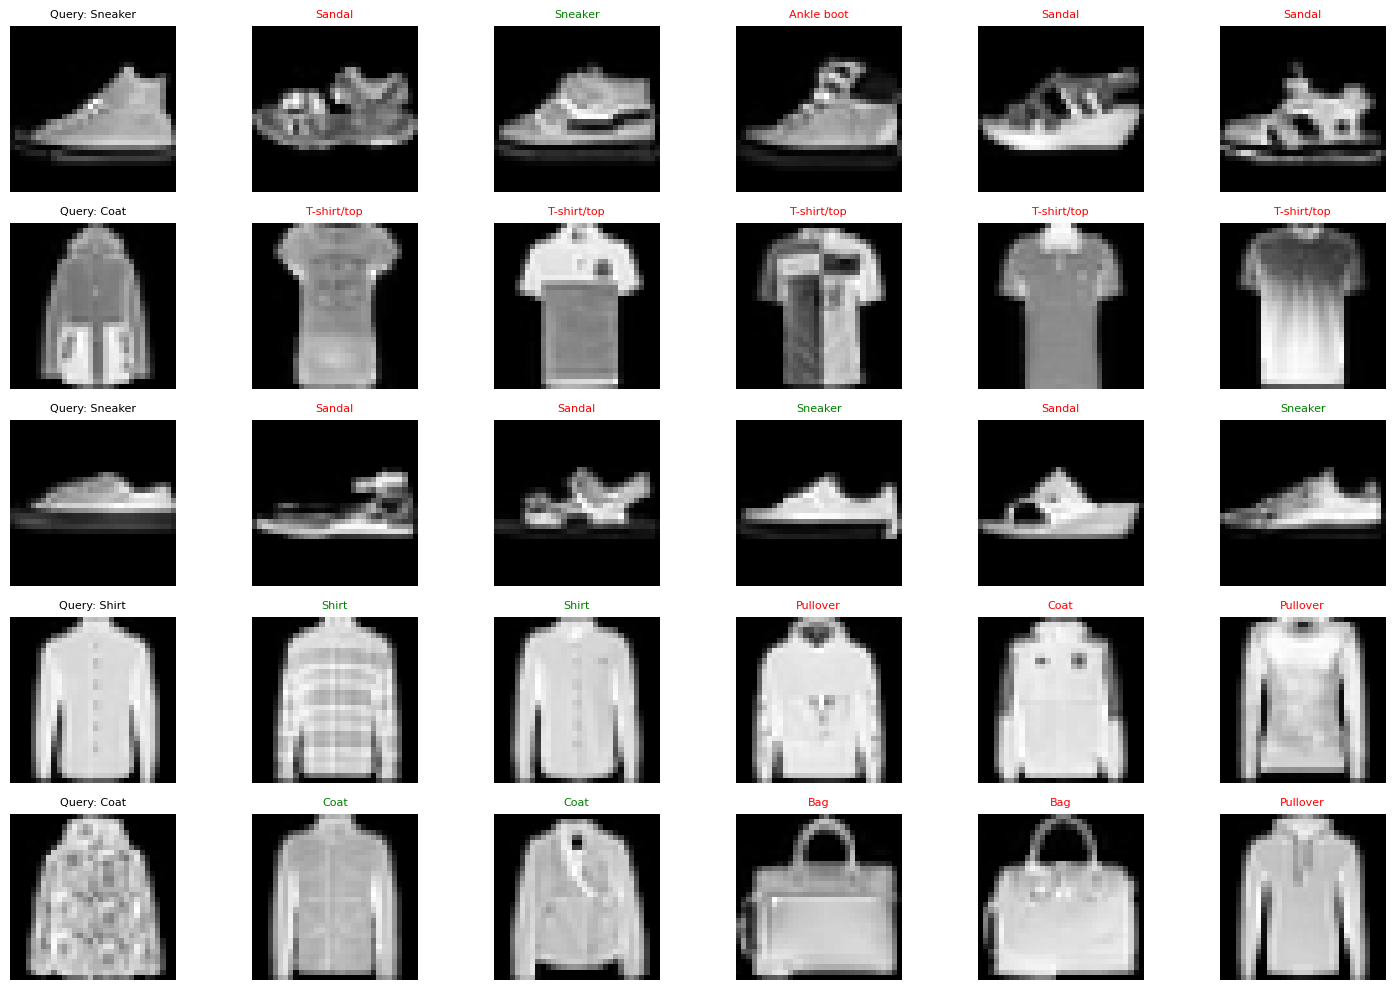

All visualizations have been saved as PNG files in the current directory.


In [4]:
def load_fashion_mnist(batch_size=64, subset_fraction=0.2, selected_classes=None):
    transform_train = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.ColorJitter(brightness=0.2, contrast=0.2),
      transforms.ToTensor(),
      transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # convert 1 channel to 3
    ])

    transform_test = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor(),
      transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])

    train_full = torchvision.datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )

    test_full = torchvision.datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )

    # filter by classes and subset data
    if selected_classes is not None:
        train_indices = [i for i, (_, label) in enumerate(train_full) if label in selected_classes]
        test_indices = [i for i, (_, label) in enumerate(test_full) if label in selected_classes]

        train_full = Subset(train_full, train_indices)
        test_full = Subset(test_full, test_indices)

    if subset_fraction < 1.0:
        train_size = int(len(train_full) * subset_fraction)
        test_size = int(len(test_full) * subset_fraction)

        train_indices = random.sample(range(len(train_full)), train_size)
        test_indices = random.sample(range(len(test_full)), test_size)

        train_subset = Subset(train_full, train_indices)
        test_subset = Subset(test_full, test_indices)
    else:
        train_subset = train_full
        test_subset = test_full

    # split training data and create validation sets
    train_size = int(0.9 * len(train_subset))
    val_size = len(train_subset) - train_size
    train_dataset, val_dataset = random_split(train_subset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_subset, batch_size=batch_size)

    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    if selected_classes:
        # filter class names
        class_names = [class_names[i] for i in selected_classes]

    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_subset)}")

    return train_loader, val_loader, test_loader, class_names

# Patches and Positional Encoding
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, embed_dim=64, img_size=32):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        # x shape: [batch_size, channels, height, width]
        # Output shape: [batch_size, num_patches, embed_dim]
        x = self.proj(x)  # [batch_size, embed_dim, grid_size, grid_size]
        x = x.flatten(2)  # [batch_size, embed_dim, num_patches]
        x = x.transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        return x

# Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_channels=3,
        embed_dim=64,
        depth=6,
        num_heads=4,
        mlp_ratio=4.0,
        dropout=0.1,
        attn_dropout=0.1,
        embedding_dropout=0.1,
        embedding_dim=128,
        num_classes=10
    ):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embed_dim=embed_dim,
            img_size=img_size
        )
        num_patches = self.patch_embed.num_patches

        # Class token and positional embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        # Embedding dropout
        self.dropout = nn.Dropout(embedding_dropout)

        # Transformer encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=int(embed_dim * mlp_ratio),
                dropout=dropout,
                activation="gelu",
                batch_first=True
            ),
            num_layers=depth
        )

        # MLP head for embeddings
        self.embedding_layer = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embedding_dim),
            nn.GELU()
        )

        # Classification head
        self.head = nn.Linear(embedding_dim, num_classes)

        # Initialize weights
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x, return_embeddings=False):
        # Patch embedding
        x = self.patch_embed(x)  # [batch_size, num_patches, embed_dim]

        # Add class token
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)  # [batch_size, num_patches + 1, embed_dim]

        # Add positional embedding
        x = x + self.pos_embed
        x = self.dropout(x)

        # Apply transformer
        x = self.transformer(x)

        # Take class token for classification
        cls_token_final = x[:, 0]

        # Apply embedding layer
        embeddings = self.embedding_layer(cls_token_final)

        # Apply classification head
        logits = self.head(embeddings)

        if return_embeddings:
            return logits, embeddings
        else:
            return logits

# Metric Learning Loss Functions
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        positive_dist = torch.sum((anchor - positive) ** 2, dim=1)
        negative_dist = torch.sum((anchor - negative) ** 2, dim=1)

        losses = F.relu(positive_dist - negative_dist + self.margin)
        return torch.mean(losses)

# Metric learning training with triplet loss
def train_with_metric_learning(model, train_loader, val_loader, optimizer, scheduler, num_epochs=15, save_path='best_model.pth'):
    classification_criterion = nn.CrossEntropyLoss()
    triplet_criterion = TripletLoss(margin=1.0)

    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_cls_loss = 0.0
        running_triplet_loss = 0.0
        correct = 0
        total = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs, embeddings = model(inputs, return_embeddings=True)

            # Classification loss
            cls_loss = classification_criterion(outputs, labels)

            # Triplet loss (if we have enough classes in the batch)
            triplet_loss = torch.tensor(0.0).to(device)
            unique_labels = torch.unique(labels)

            # Only compute triplet loss if we have at least 2 classes in the batch
            if len(unique_labels) >= 2:
                # For each anchor, find a positive and negative
                for label in unique_labels:
                    mask_anchor = (labels == label)
                    mask_negative = (labels != label)

                    if mask_anchor.sum() >= 2 and mask_negative.sum() >= 1:
                        # Get anchors and positives (same class)
                        anchor_indices = torch.where(mask_anchor)[0]
                        positive_indices = anchor_indices[torch.randperm(len(anchor_indices))]

                        # Ensure anchor and positive are different
                        mask_diff = (anchor_indices != positive_indices)
                        if mask_diff.sum() > 0:
                            anchor_indices = anchor_indices[mask_diff][:1]  # Take just one
                            positive_indices = positive_indices[mask_diff][:1]  # Take just one

                            # Get negatives (different class)
                            negative_indices = torch.where(mask_negative)[0]
                            negative_indices = negative_indices[torch.randperm(len(negative_indices))][:1]  # Take just one

                            anchor_embeds = embeddings[anchor_indices]
                            positive_embeds = embeddings[positive_indices]
                            negative_embeds = embeddings[negative_indices]

                            batch_triplet_loss = triplet_criterion(anchor_embeds, positive_embeds, negative_embeds)
                            triplet_loss += batch_triplet_loss

            # Total loss
            loss = cls_loss + 0.5 * triplet_loss

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_cls_loss += cls_loss.item() * inputs.size(0)
            running_triplet_loss += triplet_loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_bar.set_postfix(
                loss=loss.item(),
                cls_loss=cls_loss.item(),
                triplet=triplet_loss.item(),
                acc=correct/total
            )

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_cls_loss = running_cls_loss / len(train_loader.dataset)
        epoch_triplet_loss = running_triplet_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        print(f"Train - Cls Loss: {epoch_cls_loss:.4f}, Triplet Loss: {epoch_triplet_loss:.4f}")

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = classification_criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                val_bar.set_postfix(loss=loss.item(), acc=correct/total)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Adjust learning rate
        if scheduler:
            scheduler.step()

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved with validation accuracy: {best_val_acc:.4f}")

    print(f"Best validation accuracy: {best_val_acc:.4f}")
    return train_losses, val_losses, train_accs, val_accs


def evaluate_model(model, test_loader, class_names=None, plot_confusion=True):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end_time = time.time()
    elapsed_time = end_time - start_time
    accuracy = correct / total

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Evaluation Time: {elapsed_time:.2f} seconds")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    if plot_confusion:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(xticks_rotation=45, cmap='Blues')
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    return accuracy, np.array(all_preds), np.array(all_labels), cm

# Extract embeddings
def extract_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Extracting embeddings"):
            inputs = inputs.to(device)
            _, batch_embeddings = model(inputs, return_embeddings=True)
            embeddings.append(batch_embeddings.cpu().numpy())
            labels.append(targets.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)

    return embeddings, labels

# Compute pairwise distances between embeddings
def compute_distance_matrix(embeddings, metric='euclidean'):
    """Compute pairwise distances between embeddings"""
    if metric == 'euclidean':
        # Euclidean distance
        sq_dists = torch.cdist(
            torch.tensor(embeddings),
            torch.tensor(embeddings),
            p=2
        ).square().numpy()
        return sq_dists
    elif metric == 'cosine':
        # Cosine similarity
        normalized = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
        similarities = np.dot(normalized, normalized.T)
        # Convert to distance (1 - similarity)
        return 1 - similarities
    else:
        raise ValueError(f"Unknown metric: {metric}")

# Precision at K
def precision_at_k(distance_matrix, labels, k=5):
    """Calculate precision@k for retrieval"""
    n = distance_matrix.shape[0]
    # For each query, get the indices of the k closest items
    neighbors = np.argsort(distance_matrix, axis=1)[:, 1:k+1]  # Skip the first one (self)

    # Check if neighbors have the same label
    precision = 0
    for i in range(n):
        query_label = labels[i]
        neighbor_labels = labels[neighbors[i]]
        precision += np.mean(neighbor_labels == query_label)

    return precision / n

# Visualize nearest neighbors
def visualize_neighbors(data_loader, embeddings, labels, class_names, num_queries=5, k=5):
    """Visualize query images and their nearest neighbors"""
    # Get images and their corresponding labels/embeddings
    all_images = []
    all_indices = []

    # Extract a few images for visualization
    for batch_idx, (images, batch_labels) in enumerate(data_loader):
        all_images.append(images)
        all_indices.extend(range(batch_idx * data_loader.batch_size,
                          min((batch_idx + 1) * data_loader.batch_size, len(data_loader.dataset))))
        if len(all_indices) >= 1000:  # Limit the number of images to process
            break

    all_images = torch.cat(all_images, dim=0)

    # Compute distances between embeddings
    distances = compute_distance_matrix(embeddings)

    # Select random query images
    query_indices = np.random.choice(len(all_indices), num_queries, replace=False)

    plt.figure(figsize=(15, num_queries * 2))

    for i, query_idx in enumerate(query_indices):
        real_query_idx = all_indices[query_idx]
        query_label = labels[real_query_idx]

        # Get k nearest neighbors
        neighbor_indices = np.argsort(distances[real_query_idx])
        neighbor_indices = neighbor_indices[1:k+1]  # Skip the first one (self)

        # Display query image
        plt.subplot(num_queries, k+1, i*(k+1) + 1)
        img = all_images[query_idx].permute(1, 2, 0).numpy()
        img = img[:, :, 0]  # Take only first channel for display
        plt.imshow(img, cmap='gray')
        plt.title(f"Query: {class_names[query_label]}", fontsize=8)
        plt.axis('off')

        # Display nearest neighbors
        for j, neighbor_idx in enumerate(neighbor_indices):
            real_neighbor_idx = all_indices[neighbor_idx]
            neighbor_label = labels[real_neighbor_idx]

            plt.subplot(num_queries, k+1, i*(k+1) + j + 2)
            img = all_images[neighbor_idx].permute(1, 2, 0).numpy()
            img = img[:, :, 0]
            plt.imshow(img, cmap='gray')

            # Color the title based on if it's the same class
            color = 'green' if neighbor_label == query_label else 'red'
            plt.title(f"{class_names[neighbor_label]}", fontsize=8, color=color)
            plt.axis('off')

    plt.tight_layout()
    plt.savefig('fashion_mnist_neighbors.png')
    plt.show()

# Visualize embeddings
def visualize_embeddings(embeddings, labels, class_names):
    print("Performing t-SNE dimensionality reduction...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=labels,
        cmap='tab10',
        alpha=0.7,
        s=10
    )
    plt.colorbar(scatter, ticks=range(len(class_names)))
    plt.title('t-SNE visualization of Fashion MNIST embeddings')
    plt.tight_layout()

    # Add legend
    handles, _ = scatter.legend_elements()
    plt.legend(handles, class_names, loc="upper right", title="Classes")

    plt.savefig('fashion_mnist_embeddings_pytorch.png')
    plt.show()

# Plot training history
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('fashion_mnist_training_history_pytorch.png')
    plt.show()

# Main function
def main():
    # Hyperparameters
    batch_size = 128
    num_epochs = 25
    learning_rate = 3e-4
    weight_decay = 1e-4

    # Load data with subset
    subset_fraction = 1

    train_loader, val_loader, test_loader, class_names = load_fashion_mnist(
        batch_size=batch_size,
        subset_fraction=subset_fraction
    )

    # Number of classes
    num_classes = len(class_names)

    # Create model
    model = VisionTransformer(
        img_size=32,
        patch_size=4,
        in_channels=3,
        embed_dim=64,
        depth=6,
        num_heads=4,
        mlp_ratio=4.0,
        dropout=0.1,
        embedding_dim=128,
        num_classes=num_classes
    ).to(device)

    # Print model summary
    print(model)
    num_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {num_params:,}")

    # Create optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Create output directory for saving results
    os.makedirs('results', exist_ok=True)
    model_save_path = 'results/best_model.pth'

    # Train the model with metric learning
    train_losses, val_losses, train_accs, val_accs = train_with_metric_learning(
        model,
        train_loader,
        val_loader,
        optimizer,
        scheduler,
        num_epochs=num_epochs,
        save_path=model_save_path
    )

    # Plot training history
    plot_training_history(train_losses, val_losses, train_accs, val_accs)

    # Load best model
    model.load_state_dict(torch.load(model_save_path))

    # Evaluate model
    accuracy, all_preds, all_labels, confusion_matrix = evaluate_model(model, test_loader)

    # Extract embeddings
    test_embeddings, test_labels = extract_embeddings(model, test_loader)

    # Visualize embeddings
    visualize_embeddings(test_embeddings, test_labels, class_names)

    # Calculate precision@k
    distances = compute_distance_matrix(test_embeddings)
    prec_at_5 = precision_at_k(distances, test_labels, k=5)
    print(f"Precision@5 for retrieval: {prec_at_5:.4f}")

    # Visualize nearest neighbors
    visualize_neighbors(test_loader, test_embeddings, test_labels, class_names)

    print("All visualizations have been saved as PNG files in the current directory.")

if __name__ == "__main__":
    main()